## MATH/STAT 4450/8456 Contest3

Description of variables  
• recordID: Row ID.  
• orderID: Order ID. Different rows may have the same order ID.  
• orderDate: Order date.  
• itemID: Item ID. One order may have multiple items.  
• colorCode: Color code of the item.  
• sizeCode: Size code of the item.  
• typeCode: Type code of the item.  
• price: Price of the item.  
• recommendedPrice: Recommended retail price.  
• voucherID: Voucher ID.  
• voucherAmount: Voucher value PER ORDER.  
• customerID: Customer ID.  
• deviceCode: Device type.  
• paymentCode: Payment type.  
• return: If the item is returned or not. 1: yes. 0: no.


1. Create the most accurate classifier that you can for the data, as measured by the entire test data. 2. Write a 10-18 page slides summarizing your approach to

(a) cleaning and preparing the data for modeling, 

(b) formulating the model design matrix,

(c) building the model and tuning parameters,

(d) validating the model by training & validation sets, or other approaches,

(e) comparing results from all attempts,

(f) findings from the data and challenges from this contest.


### Step 1: Data Preprocessing

In [1]:
# Import required libraries
from DataPreparation import DataPrep
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [2]:
train = pd.read_csv('train.csv')
len_train = len(train)
test = pd.read_csv('test.csv')
all = pd.concat((train, test), sort=False)
train.tail()

,recordID,orderID,orderDate,itemID,colorCode,sizeCode,typeCode,price,recommendedPrice,voucherID,voucherAmount,customerID,deviceCode,paymentCode,return
423892,423893,R1141853,2022-04-30,A1000710,1079,40,3,29.99,29.99,NONE,0.0,C1035684,A,A,0
423893,423894,R1141853,2022-04-30,A1001076,3079,40,3,29.99,29.99,NONE,0.0,C1035684,A,A,1
423894,423895,R1141853,2022-04-30,A1002168,1001,40,9,29.99,29.99,NONE,0.0,C1035684,A,A,1
423895,423896,R1141854,2022-04-30,A1001083,1001,44,3,17.99,17.99,NONE,0.0,C1048304,B,A,0
423896,423897,R1141854,2022-04-30,A1001083,1493,44,3,17.99,17.99,NONE,0.0,C1048304,B,A,0


In [3]:
all_cleaned = DataPrep().run(all)
all_cleaned.fillna(0, inplace=True)
all_cleaned.tail()

,recordID,orderID,orderDate,itemID,price,voucherID,voucherAmount,customerID,return,orderDateYear,...,typeCode_9,typeCode_13,typeCode_14,typeCode_15,typeCode_17,typeCode_26,typeCode_45,typeCode_50,typeCode_90,typeCode_99
695628,695629,1226699,2022-06-30,1001900,35.00,1000415,10.0,1009246,0.0,2022,...,0,0,0,0,0,0,0,0,0,0
695629,695630,1226699,2022-06-30,1002881,12.00,1000415,10.0,1009246,0.0,2022,...,0,0,0,0,1,0,0,0,0,0
695630,695631,1226699,2022-06-30,1003174,29.99,1000415,10.0,1009246,0.0,2022,...,0,0,0,0,0,0,0,0,0,0
695631,695632,1226699,2022-06-30,1003191,25.99,1000415,10.0,1009246,0.0,2022,...,0,0,0,0,0,0,0,0,0,0
695632,695633,1226699,2022-06-30,1003191,25.99,1000415,10.0,1009246,0.0,2022,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train_df = all_cleaned[0:len_train]
test_df = all_cleaned[len_train:]

## Step: feature selection

Feature selection doesn't improve the accuracy. Accuracy on the validation set:  0.6404. will focus on feature engineering.

In [31]:
# Calculate the correlation matrix
correlation_matrix = train_df.corr()
correlation_values = correlation_matrix['return'].abs().sort_values(ascending=False)

/var/folders/85/3hk_g8w922zfg2gmpw407zj00000gn/T/ipykernel_41867/535399229.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_df.corr()


In [32]:
# Exclude the 'return' column itself and select the top 12 features
top_correlated_features = correlation_values[correlation_values.index != 'return'].head(12)
top_correlated_feature_names = top_correlated_features.index.tolist()
top_correlated_features

pricePerOrder          0.213346
itemsPerOrderID        0.162038
price                  0.139856
paymentCode_encoded    0.111823
typeCode_17            0.091577
sizeCode_I             0.083123
typeCode_3             0.082268
colorCode_8888         0.062647
typeCode_45            0.061067
sizeCode_A             0.059708
typeCode_8             0.053050
itemID                 0.044441
Name: return, dtype: float64

In [35]:
top_correlated_feature_names

['pricePerOrder',
 'itemsPerOrderID',
 'price',
 'paymentCode_encoded',
 'typeCode_17',
 'sizeCode_I',
 'typeCode_3',
 'colorCode_8888',
 'typeCode_45',
 'sizeCode_A',
 'typeCode_8',
 'itemID']

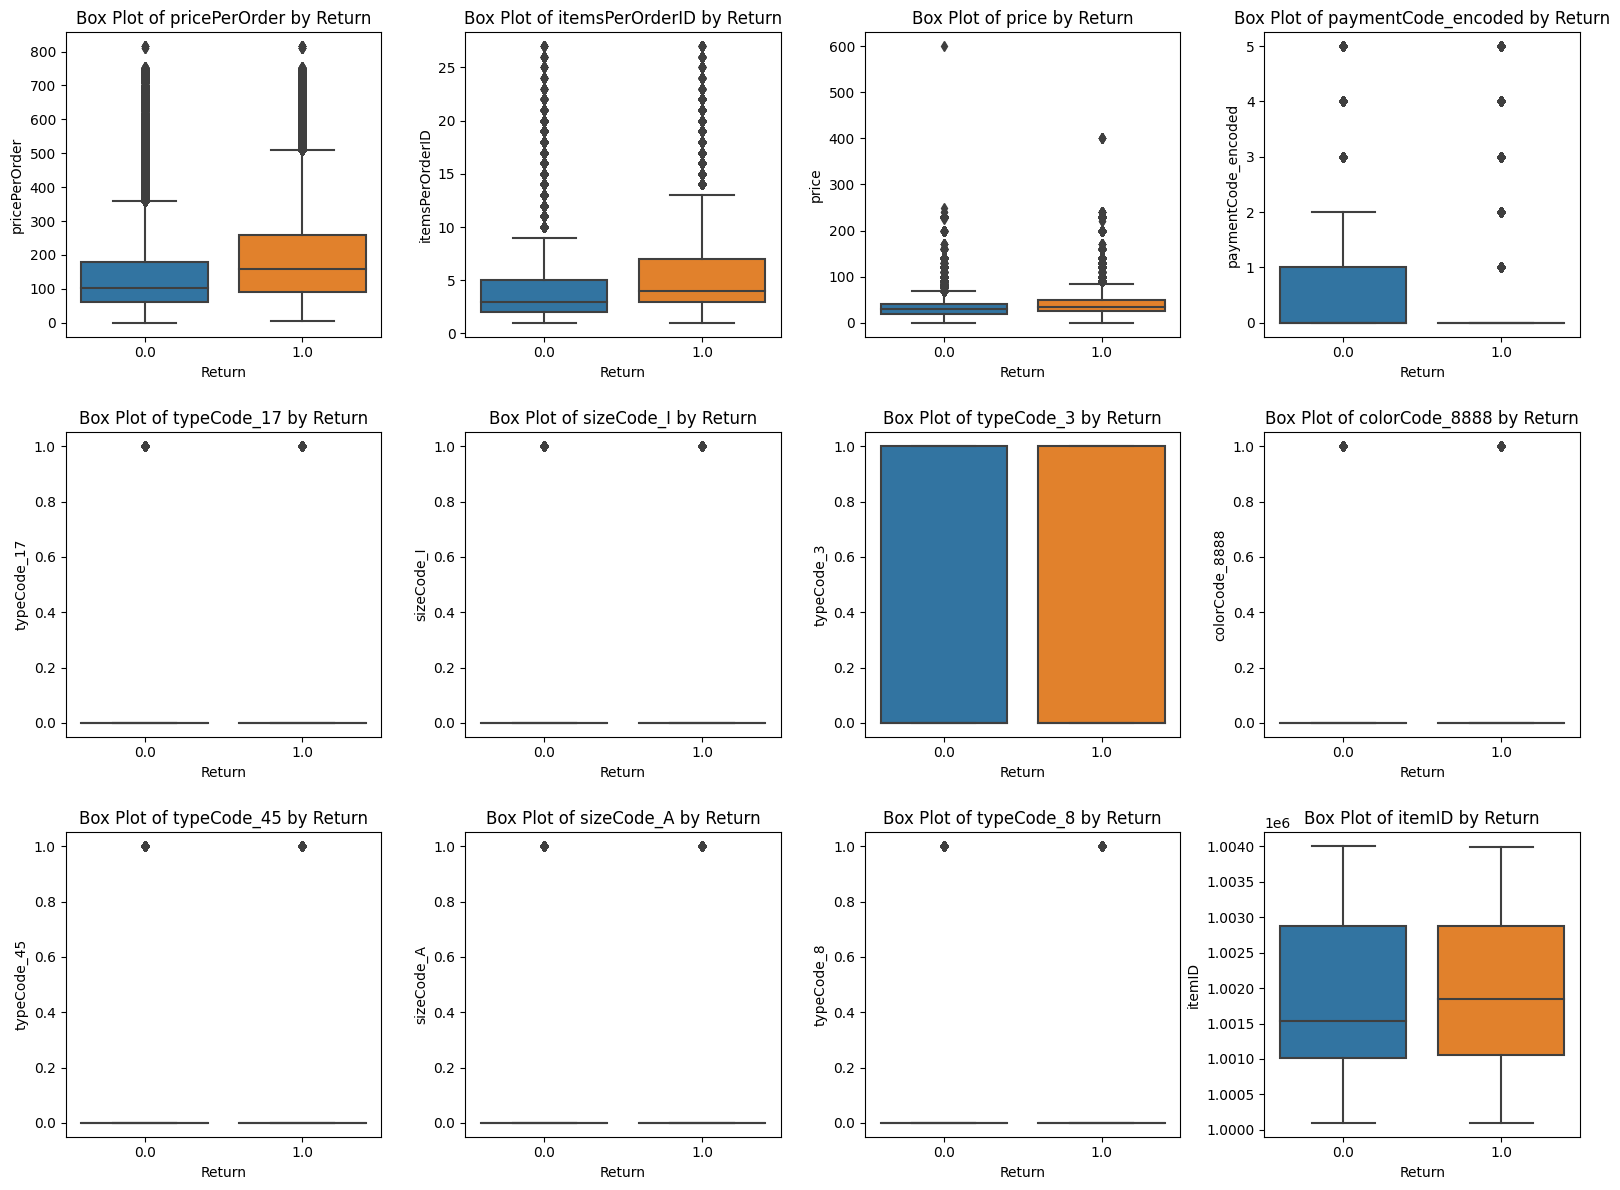

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the features to plot
features = ['pricePerOrder', 'itemsPerOrderID', 'price', 'paymentCode_encoded', 'typeCode_17',
            'sizeCode_I', 'typeCode_3', 'colorCode_8888', 'typeCode_45', 'sizeCode_A', 'typeCode_8', 'itemID']

# Create subplots for each feature
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
fig.subplots_adjust(hspace=0.5)

# Iterate over each feature and create a box plot
for i, feature in enumerate(features):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    
    sns.boxplot(data=train_df, x='return', y=feature, ax=ax)
    ax.set_xlabel('Return')
    ax.set_ylabel(feature)
    ax.set_title(f'Box Plot of {feature} by Return')

# Remove empty subplots if the number of features is less than 12
if len(features) < 12:
    for i in range(len(features), 12):
        row = i // 4
        col = i % 4
        fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()


In [ ]:
X = train_df[top_correlated_feature_names]
y = train_df['return']

# Validation set approach
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()

# Support Vector Machines
from sklearn.svm import SVC
models['Support Vector Machines'] = SVC(kernel='linear', probability=True)

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier(criterion = 'entropy', max_depth= 8, min_samples_leaf = 3, min_samples_split= 5)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier(criterion = 'gini', max_depth= 8, max_features = 'log2')

from xgboost import XGBClassifier
models['XGBoost'] = XGBClassifier(max_depth = 3, min_child_weight= 3,learning_rate =0.1, n_estimators=140, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1)

In [ ]:
# With all metrics stored, use pandas to view the data as a table
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy, precision, recall = {}, {}, {}

for key in models.keys():
    
    # Fit the classifier
    models[key].fit(X_train, y_train)
    
    # Make predictions
    predictions = models[key].predict(X_val)
    
    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_val)
    precision[key] = precision_score(predictions, y_val)
    recall[key] = recall_score(predictions, y_val)

In [ ]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model

## Step: Validation Approach

(i) Data filtering -> Data cleaning -> Regular 5-fold CV -> Model Fitting -> Report the CV error.

In [13]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
validation_methods = []
mean_accuracy = []
mean_mse = []

X = train_df[top_correlated_feature_names]
y = train_df['return']

# Create the XGBoost classifier object
xgb_model = XGBClassifier(max_depth = 8, 
                        min_child_weight= 3,
                        objective='binary:logistic',
                        nthread=4,
                        scale_pos_weight=1,
                        n_estimators = 200,
                        learning_rate=0.1,
                        gamma=0, 
                        subsample=0.8, 
                        colsample_bytree=0.8
                        )
xgb_model.fit(X, y)
# Perform 5-fold cross-validation
cv5_accuracy_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')
cv5_mse_scores = -cross_val_score(xgb_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv5_mean_accuracy = round(np.mean(cv5_accuracy_scores),4)
cv5_mean_mse = round(np.mean(cv5_mse_scores),4)
mean_accuracy.append(cv5_mean_accuracy)
mean_mse.append(cv5_mean_mse)
validation_methods.append("Regular 5-fold CV")
# Print the cross-validation scores
print("Cross-Validation Accuracy Scores:", cv5_accuracy_scores)
print("Mean Accuracy: ", cv5_mean_accuracy)
print("Cross-Validation MSE Scores: ", cv5_mse_scores)
print("Mean MSE: ",cv5_mean_mse)
    

Cross-Validation Accuracy Scores: [0.64096485 0.64595423 0.64311917 0.64618597 0.64399203]
Mean Accuracy:  0.644
Cross-Validation MSE Scores:  [0.35903515 0.35404577 0.35688083 0.35381403 0.35600797]
Mean MSE:  0.356


In [14]:
test_df = test_df[top_correlated_feature_names]
xgb_pred = xgb_model.predict(test_df)
df_submission = pd.read_csv("sample_submission.csv")
df_submission['return'] = xgb_pred
print(df_submission['return'].value_counts())
df_submission.to_csv('submission_xgb0.644.csv', index=False)

1    175743
0     95993
Name: return, dtype: int64


(ii) Data filtering -> Data cleaning -> Validation set approach (70-30 ratio, random sampling) -> Model Fitting -> Report the validation error.

In [20]:
from sklearn.metrics import accuracy_score, mean_squared_error
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

X = train_df[top_correlated_feature_names]
y = train_df['return']

# Validation set approach
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
xgb_model = XGBClassifier(max_depth = 8, 
                        min_child_weight= 3,
                        objective='binary:logistic',
                        nthread=4,
                        scale_pos_weight=1,
                        n_estimators = 200,
                        learning_rate=0.1,
                        gamma=0, 
                        subsample=0.8, 
                        colsample_bytree=0.8
                        )
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=10)
y_pred = xgb_model.predict(X_val)
accuracy = round(accuracy_score(y_val, y_pred),4)
val_error = round(mean_squared_error(y_val, y_pred),4)
mean_accuracy.append(accuracy)
mean_mse.append(val_error)
validation_methods.append("70-30 Ration random sampling")
print(f"Accuracy on the validation set: {accuracy} ")
print(f"Validation error: {val_error}")


[0]	validation_0-logloss:0.68401
[10]	validation_0-logloss:0.64333
[20]	validation_0-logloss:0.63540
[30]	validation_0-logloss:0.63269
[40]	validation_0-logloss:0.63150
[50]	validation_0-logloss:0.63061
[60]	validation_0-logloss:0.63008
[70]	validation_0-logloss:0.62937
[80]	validation_0-logloss:0.62899
[90]	validation_0-logloss:0.62830
[100]	validation_0-logloss:0.62798
[110]	validation_0-logloss:0.62774
[120]	validation_0-logloss:0.62740
[130]	validation_0-logloss:0.62710
[140]	validation_0-logloss:0.62686
[150]	validation_0-logloss:0.62670
[160]	validation_0-logloss:0.62655
[170]	validation_0-logloss:0.62634
[180]	validation_0-logloss:0.62622
[190]	validation_0-logloss:0.62612
[199]	validation_0-logloss:0.62597
Accuracy on the validation set: 0.6487 
Validation error: 0.3513


Data filtering -> Data cleaning -> Validation set approach (77-23)ratio, random sampling) -> Model Fitting -> Report the validation error.

In [22]:
from sklearn.metrics import accuracy_score, mean_squared_error
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

X = train_df[top_correlated_feature_names]
y = train_df['return']

# Validation set approach
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.23, random_state=42)
xgb_model = XGBClassifier(max_depth = 8, 
                        min_child_weight= 3,
                        objective='binary:logistic',
                        nthread=4,
                        scale_pos_weight=1,
                        n_estimators = 200,
                        learning_rate=0.1,
                        gamma=0, 
                        subsample=0.8, 
                        colsample_bytree=0.8
                        )
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=10)
y_pred = xgb_model.predict(X_val)
accuracy = round(accuracy_score(y_val, y_pred),4)
val_error = round(mean_squared_error(y_val, y_pred),4)
mean_accuracy.append(accuracy)
mean_mse.append(val_error)
validation_methods.append("77-23 Ration random sampling")
print(f"Accuracy on the validation set: {accuracy} ")
print(f"Validation error: {val_error}")


[0]	validation_0-logloss:0.68403
[10]	validation_0-logloss:0.64385
[20]	validation_0-logloss:0.63554
[30]	validation_0-logloss:0.63326
[40]	validation_0-logloss:0.63217
[50]	validation_0-logloss:0.63139
[60]	validation_0-logloss:0.63056
[70]	validation_0-logloss:0.62997
[80]	validation_0-logloss:0.62940
[90]	validation_0-logloss:0.62899
[100]	validation_0-logloss:0.62875
[110]	validation_0-logloss:0.62845
[120]	validation_0-logloss:0.62812
[130]	validation_0-logloss:0.62784
[140]	validation_0-logloss:0.62766
[150]	validation_0-logloss:0.62742
[160]	validation_0-logloss:0.62720
[170]	validation_0-logloss:0.62698
[180]	validation_0-logloss:0.62681
[190]	validation_0-logloss:0.62662
[199]	validation_0-logloss:0.62652
Accuracy on the validation set: 0.65 
Validation error: 0.35


In [11]:
test_df = test_df[top_correlated_feature_names]
xgb_pred = xgb_model.predict(test_df)
df_submission = pd.read_csv("sample_submission.csv")
df_submission['return'] = xgb_pred
print(df_submission['return'].value_counts())
df_submission.to_csv('submission_xgb0.65.csv', index=False)

1    173863
0     97873
Name: return, dtype: int64


(iii) Time-series split: We can use time-series split to validate our model.

In [15]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_squared_error

X = train_df[top_correlated_feature_names]
y = train_df['return']

# Create the XGBoost classifier object
xgb_model = XGBClassifier(max_depth=8, 
                          min_child_weight=3,
                          objective='binary:logistic',
                          nthread=4,
                          scale_pos_weight=1,
                          n_estimators=200,
                          learning_rate=0.1,
                          gamma=0, 
                          subsample=0.8, 
                          colsample_bytree=0.8
                          )
xgb_model.fit(X, y)
# Define the time-based cross-validation splitter
tscv = TimeSeriesSplit(n_splits=5)

# Perform time-based cross-validation
accuracy_scores = cross_val_score(xgb_model, X, y, cv=tscv, scoring='accuracy')
mse_scores = -cross_val_score(xgb_model, X, y, cv=tscv, scoring='neg_mean_squared_error')

tscv_mean_accuracy = round(np.mean(accuracy_scores),4)
tscv_mean_mse = round(np.mean(mse_scores),4)
mean_accuracy.append(tscv_mean_accuracy)
mean_mse.append(tscv_mean_mse)
validation_methods.append("Time-series 5-fold CV")
# Print the cross-validation scores
print("Cross-Validation Accuracy Scores:", accuracy_scores)
print("Mean Accuracy: ", tscv_mean_accuracy)
print("Cross-Validation MSE Scores: ", mse_scores)
print("Mean MSE: ",tscv_mean_mse)

Cross-Validation Accuracy Scores: [0.63669691 0.63831052 0.63661198 0.64378831 0.64353352]
Mean Accuracy:  0.6398
Cross-Validation MSE Scores:  [0.36330309 0.36168948 0.36338802 0.35621169 0.35646648]
Mean MSE:  0.3602


In [16]:
test_df = test_df[top_correlated_feature_names]
xgb_pred = xgb_model.predict(test_df)
df_submission = pd.read_csv("sample_submission.csv")
df_submission['return'] = xgb_pred
print(df_submission['return'].value_counts())
df_submission.to_csv('submission_xgb0.6398.csv', index=False)

1    175743
0     95993
Name: return, dtype: int64


  (iv) Data filtering -> 5-fold cross validation by orderDate (split the 90 days into consecutive 5 folds of 18 days each, like 12/1-12/18, 12/19-1/5, etc.) -> Data cleaning on training (4 folds) and validation (1 fold) sets iteratively -> Model Fitting for 5 times -> Report the CV error.

In [17]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
import numpy as np
# Define a list to store the cross-validation scores
cv_scores = []
accuracyScores = []

# Define the start and end dates
train['orderDate'] = pd.to_datetime(train['orderDate'], format='%Y-%m-%d')
start_date = pd.to_datetime('2022-01-01')
end_date = pd.to_datetime('2022-04-30')

# Calculate the total number of days
total_days = (end_date - start_date).days

# Calculate the number of days in each fold
fold_length = total_days // 5

# Define the date ranges for each fold
fold_1_start = start_date
fold_1_end = start_date + pd.DateOffset(days=fold_length - 1)

fold_2_start = fold_1_end + pd.DateOffset(days=1)
fold_2_end = fold_2_start + pd.DateOffset(days=fold_length - 1)

fold_3_start = fold_2_end + pd.DateOffset(days=1)
fold_3_end = fold_3_start + pd.DateOffset(days=fold_length - 1)

fold_4_start = fold_3_end + pd.DateOffset(days=1)
fold_4_end = fold_4_start + pd.DateOffset(days=fold_length - 1)

fold_5_start = fold_4_end + pd.DateOffset(days=1)
fold_5_end = end_date

# Filter and clean the data for each fold
fold_1 = train[(train['orderDate'] >= fold_1_start) & (train['orderDate'] <= fold_1_end)]
fold_2 = train[(train['orderDate'] >= fold_2_start) & (train['orderDate'] <= fold_2_end)]
fold_3 = train[(train['orderDate'] >= fold_3_start) & (train['orderDate'] <= fold_3_end)]
fold_4 = train[(train['orderDate'] >= fold_4_start) & (train['orderDate'] <= fold_4_end)]
fold_5 = train[(train['orderDate'] >= fold_5_start) & (train['orderDate'] <= fold_5_end)]

# Clean the data for each fold using DataPrep().run()
fold_1_cleaned = DataPrep().run(fold_1.copy())
fold_2_cleaned = DataPrep().run(fold_2.copy())
fold_3_cleaned = DataPrep().run(fold_3.copy())
fold_4_cleaned = DataPrep().run(fold_4.copy())
fold_5_cleaned = DataPrep().run(fold_5.copy())

# Create the XGBoost classifier object
xgb_model = XGBClassifier(max_depth=8, 
                          min_child_weight=3,
                          objective='binary:logistic',
                          nthread=4,
                          scale_pos_weight=1,
                          n_estimators=200,
                          learning_rate=0.1,
                          gamma=0, 
                          subsample=0.8, 
                          colsample_bytree=0.8
                          )

# Validation set approach
for i in range(1, 6):
    # Split the data into training (4 folds) and validation (1 fold) sets
    if i == 1:
        train = pd.concat([fold_2_cleaned, fold_3_cleaned, fold_4_cleaned, fold_5_cleaned])
        val = fold_1_cleaned
    elif i == 2:
        train = pd.concat([fold_1_cleaned, fold_3_cleaned, fold_4_cleaned, fold_5_cleaned])
        val = fold_2_cleaned
    elif i == 3:
        train = pd.concat([fold_1_cleaned, fold_2_cleaned, fold_4_cleaned, fold_5_cleaned])
        val = fold_3_cleaned
    elif i == 4:
        train = pd.concat([fold_1_cleaned, fold_2_cleaned, fold_3_cleaned, fold_5_cleaned])
        val = fold_4_cleaned
    else:
        train = pd.concat([fold_1_cleaned, fold_2_cleaned, fold_3_cleaned, fold_4_cleaned])
        val = fold_5_cleaned

    X_train = train[top_correlated_feature_names]
    y_train = train['return']
    X_val = val[top_correlated_feature_names]
    y_val = val['return']

    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=10)
    y_pred = xgb_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    accuracyScores.append(accuracy)
    print(f"Accuracy on the validation set: {accuracy: .4f}")
    val_error = mean_squared_error(y_val, y_pred)
    print(f'Validation error: {val_error:.4f}')
    cv_scores.append(val_error)
cv24days_mean_accuracy = round(np.mean(accuracyScores),4)
cv24days_mean_mse = round(np.mean(cv_scores),4)
mean_accuracy.append(cv24days_mean_accuracy)
mean_mse.append(cv24days_mean_mse)
validation_methods.append("5Fold_CV_by_orderDate_24_days_each")
print("5Fold_CV_by_orderDate_24_days_each: \n")
print(f"Average Accuracy: {cv24days_mean_accuracy}")
print(f"CV error: {cv24days_mean_mse}")
    

[0]	validation_0-logloss:0.68458
[10]	validation_0-logloss:0.64713
[20]	validation_0-logloss:0.63963
[30]	validation_0-logloss:0.63790
[40]	validation_0-logloss:0.63747
[50]	validation_0-logloss:0.63644
[60]	validation_0-logloss:0.63629
[70]	validation_0-logloss:0.63601
[80]	validation_0-logloss:0.63586
[90]	validation_0-logloss:0.63565
[100]	validation_0-logloss:0.63548
[110]	validation_0-logloss:0.63526
[120]	validation_0-logloss:0.63516
[130]	validation_0-logloss:0.63503
[140]	validation_0-logloss:0.63506
[150]	validation_0-logloss:0.63518
[160]	validation_0-logloss:0.63526
[170]	validation_0-logloss:0.63517
[180]	validation_0-logloss:0.63510
[190]	validation_0-logloss:0.63499
[199]	validation_0-logloss:0.63491
Accuracy on the validation set:  0.6438
Validation error: 0.3562
[0]	validation_0-logloss:0.68381
[10]	validation_0-logloss:0.64337
[20]	validation_0-logloss:0.63630
[30]	validation_0-logloss:0.63439
[40]	validation_0-logloss:0.63348
[50]	validation_0-logloss:0.63287
[60]	val

In [18]:
test_df = test_df[top_correlated_feature_names]
xgb_pred = xgb_model.predict(test_df)
df_submission = pd.read_csv("sample_submission.csv")
df_submission['return'] = xgb_pred
print(df_submission['return'].value_counts())
df_submission.to_csv('submission_xgb0.6445.csv', index=False)

1    175027
0     96709
Name: return, dtype: int64


In [25]:
kaggle_score = [0.64702,0.64702,0.64113,0.64732,0.64661]
Validation_results = {
    'Validation Method': validation_methods,
    'Mean Accuracy': mean_accuracy,
    'Mean MSE': mean_mse,
    'Kaggle Score': kaggle_score
}

df = pd.DataFrame(Validation_results)
df


,Validation Method,Mean Accuracy,Mean MSE,Kaggle Score
0,Regular 5-fold CV,0.6440,0.3560,0.64702
1,Time-series 5-fold CV,0.6398,0.3602,0.64702
2,5Fold_CV_by_orderDate_24_days_each,0.6445,0.3555,0.64113
3,70-30 Ration random sampling,0.6487,0.3513,0.64732
4,77-23 Ration random sampling,0.6500,0.3500,0.64661


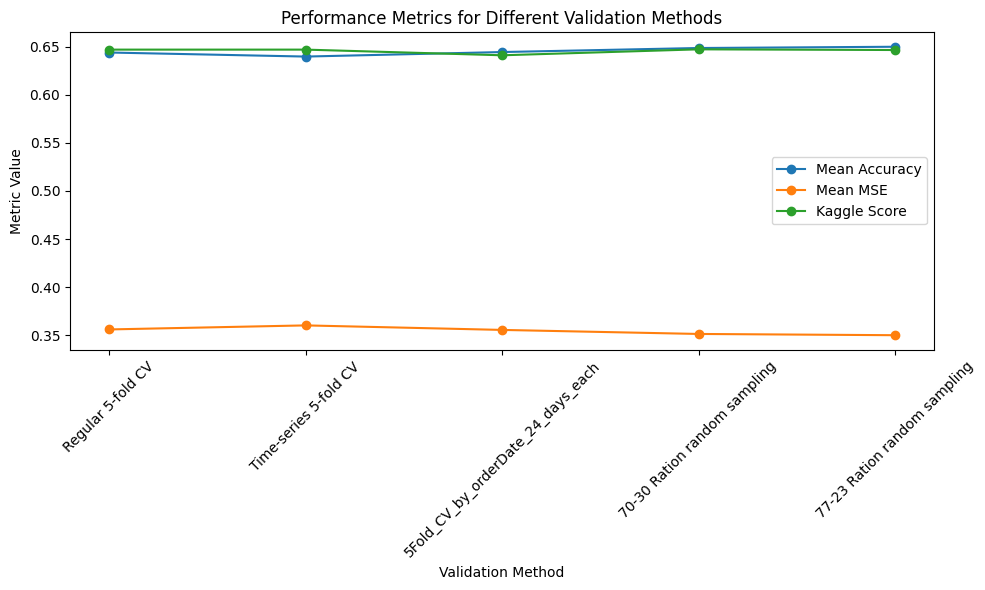

In [26]:
# Plot the mean accuracy, mean MSE, and Kaggle scores
from matplotlib import pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(validation_methods, mean_accuracy, marker='o', label='Mean Accuracy')
plt.plot(validation_methods, mean_mse, marker='o', label='Mean MSE')
plt.plot(validation_methods, kaggle_score, marker='o', label='Kaggle Score')
plt.xlabel('Validation Method')
plt.ylabel('Metric Value')
plt.title('Performance Metrics for Different Validation Methods')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



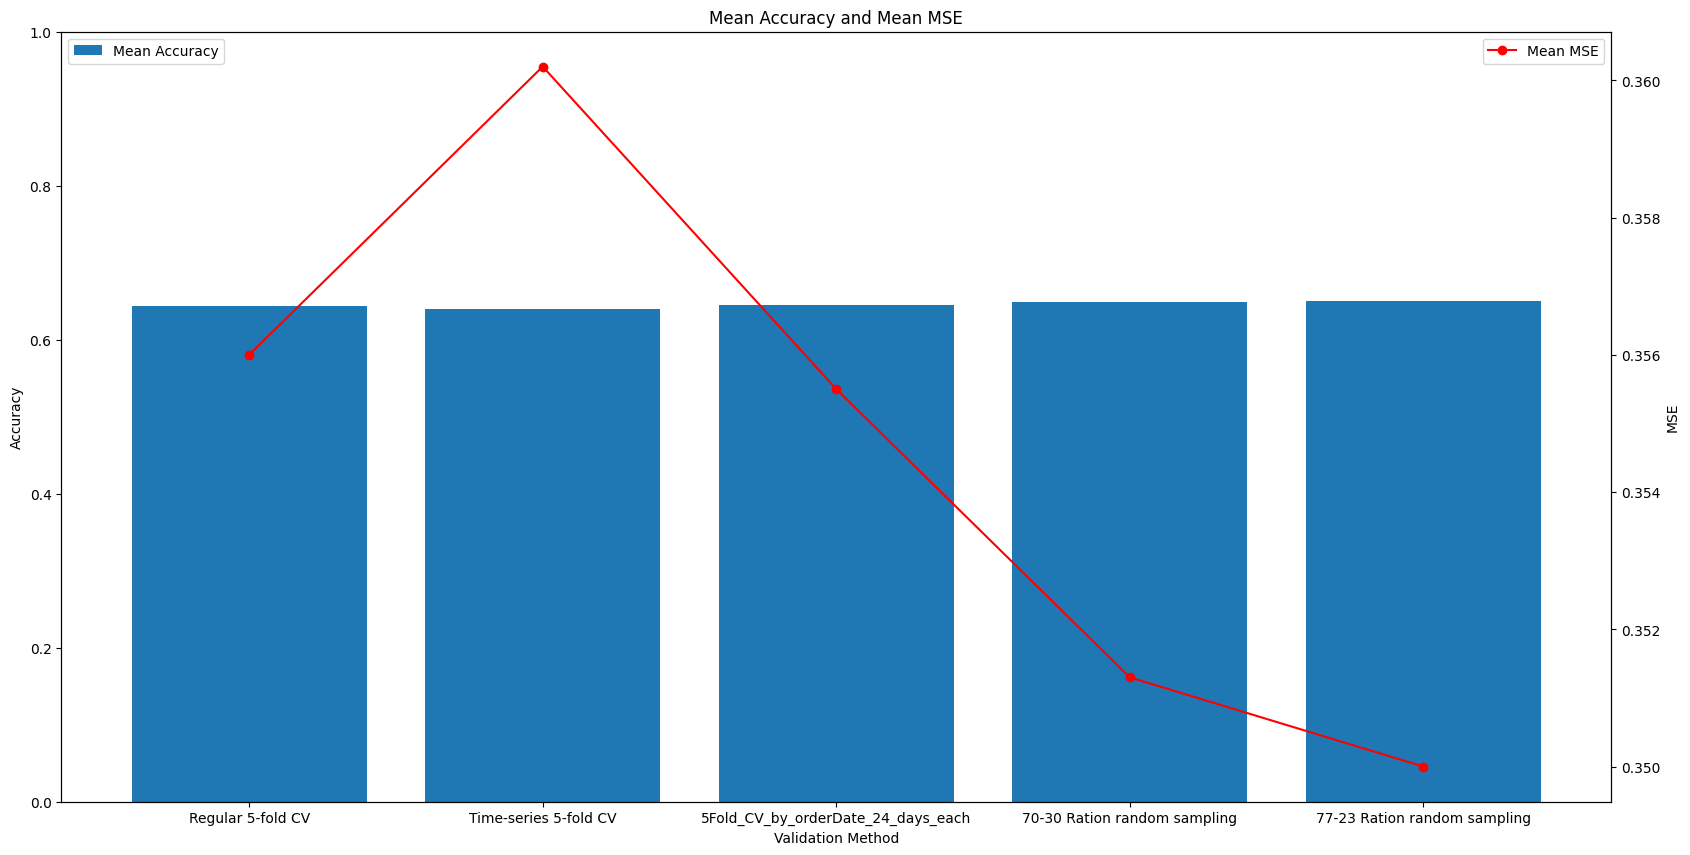

In [24]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the mean accuracy
ax.bar(validation_methods, mean_accuracy, label='Mean Accuracy')
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)

# Plot the mean MSE
ax2 = ax.twinx()
ax2.plot(validation_methods, mean_mse, color='red', marker='o', label='Mean MSE')
ax2.set_ylabel('MSE')

# Set labels and title
ax.set_xlabel('Validation Method')
ax.set_title('Mean Accuracy and Mean MSE')

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()


## Step 4: Model Compare

Method 1: XGB with full data without any feature Engineering. 

In [105]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the parameter grid for tuning
param_grid = {
    'max_depth': [6, 7, 8],
    'min_child_weight': [2, 3, 4],
    #'gamma': [0, 0.1, 0.2],
    #'subsample': [0.6, 0.7, 0.8],
    #'colsample_bytree': [0.6, 0.7, 0.8],
    #'reg_alpha': [0, 0.1, 0.5],
    #'reg_lambda': [0, 0.1, 0.5],
}

# Create the XGBClassifier object
xgb_model = XGBClassifier(
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    n_estimators = 140,
    learning_rate=0.1,
    gamma=0, 
    subsample=0.8, 
    colsample_bytree=0.8
)

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid,
                            scoring='accuracy',
                            cv=5)
grid_search.fit(X_train, y_train,eval_set=[(X_val, y_val)], verbose=10)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create the Random Forest classifier object
rf_model = RandomForestClassifier(criterion = 'gini', max_features = 'sqrt', random_state = 42)

# Define the parameter grid for tuning
param_grid = {
    'max_depth': [5,8],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 5],
    #'max_features': ['sqrt', 'log2'],
    #'criterion': ['gini', 'entropy'],
}

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy', verbose=20, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START max_depth=5, min_samples_leaf=2, min_samples_split=2........
[CV 1/5; 1/8] END max_depth=5, min_samples_leaf=2, min_samples_split=2;, score=0.636 total time=   7.8s
[CV 2/5; 1/8] START max_depth=5, min_samples_leaf=2, min_samples_split=2........
[CV 2/5; 1/8] END max_depth=5, min_samples_leaf=2, min_samples_split=2;, score=0.630 total time=   7.8s
[CV 3/5; 1/8] START max_depth=5, min_samples_leaf=2, min_samples_split=2........
[CV 3/5; 1/8] END max_depth=5, min_samples_leaf=2, min_samples_split=2;, score=0.632 total time=   7.8s
[CV 4/5; 1/8] START max_depth=5, min_samples_leaf=2, min_samples_split=2........
[CV 4/5; 1/8] END max_depth=5, min_samples_leaf=2, min_samples_split=2;, score=0.631 total time=   8.0s
[CV 5/5; 1/8] START max_depth=5, min_samples_leaf=2, min_samples_split=2........
[CV 5/5; 1/8] END max_depth=5, min_samples_leaf=2, min_samples_split=2;, score=0.633 total time=   8.4s
[CV 1/5; 2/8] S

In [135]:
from sklearn.metrics import accuracy_score
rf_model = RandomForestClassifier(max_depth = 8, 
                                  min_samples_leaf = 2, 
                                  min_samples_split =5, 
                                  criterion = 'gini', 
                                  max_features = 'log2',
                                  random_state = 42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy on the validation set: {accuracy: .4f}")

Accuracy on the validation set:  0.6374


- Deep Learning Neural Network Models

In [21]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

X = train_df.drop(['return','orderDate'], axis = 1)
y = train_df['return']

# Validation set approach
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3,
                                                   random_state=42)

In [27]:
from sklearn.discriminant_analysis import StandardScaler

sc = StandardScaler()
sc.fit(X_train)		#Apply the scaler to the X training  and X-test data sets
X_train_std = sc.transform(X_train)
X_val_std = sc.transform(X_val)


In [25]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=[30, 20, 10], 
                    max_iter=100,
                    alpha=0.01, 
                    activation='relu',
                    early_stopping=True,
                    validation_fraction=0.2,
                    n_iter_no_change=5,
                    verbose=True)
print(mlp)  			#print the parameters of the MLP classifier
mlp.fit(X_train_std, y_train)
y_pred = mlp.predict(X_val_std)


MLPClassifier(alpha=0.01, early_stopping=True, hidden_layer_sizes=[30, 20, 10],
              max_iter=100, n_iter_no_change=5, validation_fraction=0.2,
              verbose=True)
Iteration 1, loss = 0.65296895
Validation score: 0.630270
Iteration 2, loss = 0.64186823
Validation score: 0.632646
Iteration 3, loss = 0.63892166
Validation score: 0.634617
Iteration 4, loss = 0.63694973
Validation score: 0.635005
Iteration 5, loss = 0.63539898
Validation score: 0.637853
Iteration 6, loss = 0.63422468
Validation score: 0.636319
Iteration 7, loss = 0.63342848
Validation score: 0.638274
Iteration 8, loss = 0.63248341
Validation score: 0.636538
Iteration 9, loss = 0.63178203
Validation score: 0.637701
Iteration 10, loss = 0.63133786
Validation score: 0.638038
Iteration 11, loss = 0.63085243
Validation score: 0.636387
Iteration 12, loss = 0.63032329
Validation score: 0.637145
Iteration 13, loss = 0.62987843
Validation score: 0.637566
Validation score did not improve more than tol=0.000100 for 5

In [26]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
confusion_matrix = confusion_matrix(y_val, y_pred)
print('Confusion_matrix:')
print(confusion_matrix)
print('Accuracy: %.4f' % accuracy_score(y_val, y_pred))


Confusion_matrix:
[[33676 25859]
 [20243 47392]]
Accuracy: 0.6375


In [1]:
# Load required libraries
import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


# Create and fit a Multilayer Perceptron (MLP) classifier
def MLP_Neural_Network(arg1, arg2, arg3, arg4):
    mlp = MLPClassifier(hidden_layer_sizes=arg1, max_iter=arg2, alpha=arg3, activation=arg4)
    mlp.fit(X_train_std, y_train)
    print(mlp)  # print the parameters of the MLP classifier
    y_pred = mlp.predict(X_val_std)
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_val, y_pred)
    print('Confusion_matrix:')
    print(confusion_matrix)
    print('Accuracy: %.2f' % accuracy_score(y_val, y_pred))
    print('Training set score:%.2f' % mlp.score(X_train_std, y_train))
    print('Test set score:%.2f' % mlp.score(X_val_std, y_val))
    print('The weights: ')
    print('w0 = %.4f' % mlp.coefs_[0][0][0])
    print('w1 = %.4f' % mlp.coefs_[0][1][0])
    layers = {0: 'Input', 1: 'first', 2: 'second', 3: 'third', 4: 'fourth', 5: 'fifth', 6: 'sixth'}
    # Print the average weights between two layers
    for i, weights in enumerate(mlp.coefs_):
        print(f'w{i}:{np.mean(weights):.2f}')
    # Print the weights between two layers
    for i in range(0, len(mlp.coefs_)):
        print(f'weights between {layers[i]} layer and {layers[i + 1]} layer: \n {mlp.coefs_[i]}')


if __name__ == '__main__':
    # Prepare dictionary with different parameters
    params = {
            "hidden_layer_sizes": [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20),
                                   (30, 10, 10), (30, 10, 10), (30, 10, 10), (30, 10, 10), (30, 10, 10),
                                   (10, 10, 5, 5), (10, 10, 5, 5), (10, 10, 5, 5), (10, 10, 5, 5),
                                   (30, 10, 10, 5, 5), (30, 10, 10, 5, 5), (30, 10, 10, 5, 5), (30, 10, 10, 5, 5)],

            "max_iter": [600, 605, 655, 670, 670,
                         500, 500, 1000, 1000, 1000,
                         1000, 1500, 1500, 1500,
                         1000, 1500, 1000, 1000
                         ],
            "alpha": [0.0001, 0.0001, 0.0001, 0.0001, 0.2,
                      0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.2,
                      0.0001, 0.0001, 0.0001, 0.0001, 0.2,
                      0.0001, 0.0001, 0.0001, 0.0001, 0.2
                      ],
            "activation": ["identity", "logistic", "tanh", "relu", "relu",
                           "relu", "identity", "identity", "relu", "identity",
                           "identity", "identity", "relu", "identity",
                           "identity", "identity", "relu", "identity",
                           ]
        }
# get required parameters values from params dictionary.
    for i in range(0, len(params["max_iter"])):
        hidden_layer = params["hidden_layer_sizes"][i]
        iter_num = params["max_iter"][i]
        alpha_value = params["alpha"][i]
        activation_type = params["activation"][i]

        # call function MLP_Neural_Network with different parameters
        print('///////////////////////MPL Neural Network Running Results///////////////////////')
        MLP_Neural_Network(hidden_layer, iter_num, alpha_value, activation_type)


///////////////////////MPL Neural Network Running Results///////////////////////


NameError: name 'X_train_std' is not defined

## Step 5: Make prediction on test

In [91]:
test_df = test_df[top_correlated_feature_names]
xgb_pred = xgb_model.predict(test_df)
df_submission = pd.read_csv("sample_submission.csv")
df_submission['return'] = xgb_pred
print(df_submission['return'].value_counts())
df_submission.to_csv('submission_xgb21.csv', index=False)

1    173863
0     97873
Name: return, dtype: int64


## Step 6: Model Tuning